In [184]:
import pdal
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image
import pathlib
import subprocess
import json
import tqdm.auto as tqdm
import shapely.geometry
import numpy as np
from pycocotools.coco import COCO
import skimage.io
import open3d
from open3d.web_visualizer import draw

import numpy as np
import cv2
import zlib
import base64
import io
from PIL import Image

print(f"Using pdal version {pdal.__version__}")


def make_las_bounds(lasfolder):
    """
    geometrie las bestanden bepalen
    """
    lasfiles = [p for p in pathlib.Path(lasfolder).iterdir() if p.suffix == ".las"]
    df_las = []
    for p in tqdm.tqdm(lasfiles):
        # decode stdout from bytestring and convert to a dictionary
        result = subprocess.run(
            ["pdal", "info", str(p)], stderr=subprocess.PIPE, stdout=subprocess.PIPE
        )
        json_result = json.loads(result.stdout.decode())
        maxx, maxy, maxz, minx, miny, minz = json_result["stats"]["bbox"]["native"][
            "bbox"
        ].values()
        geom = shapely.geometry.box(minx, miny, maxx, maxy)
        df_las.append((p.stem, str(p), maxx, maxy, maxz, minx, miny, minz, geom))
    df_las = pd.DataFrame(
        df_las,
        columns=[
            "name",
            "path",
            "maxx",
            "maxy",
            "maxz",
            "minx",
            "miny",
            "minz",
            "geometry",
        ],
    )
    gdf_las = gpd.GeoDataFrame(df_las, geometry="geometry", crs="epsg:28992")
    return gdf_las


def find_tile_bounds(root_tilepath, concat=True):
    cell_files = []
    for p in pathlib.Path(root_tilepath).iterdir():
        if p.is_dir():
            cell_files += find_tile_bounds(p, concat=False)
        elif p.is_file() and p.suffix == ".gpkg" and "cells_intersect" in p.stem:
            df = gpd.read_file(p)
            df["name"] = p.stem.replace("_cells_intersects", "")
            cell_files.append(df.copy())
    if concat:
        cell_files = pd.concat(cell_files)
    return cell_files


def get_lasdata(las_filepath, xmin, xmax, ymin, ymax):
    jsondata = f"""
    [
        "{las_filepath}",
        {{
            "type":"filters.expression",
            "expression":"(X >= {xmin} && X <= {xmax} && Y >= {ymin} && Y <= {ymax})"
        }}
    ]
    """
    pipeline = pdal.Pipeline(jsondata)
    count = pipeline.execute()
    arrays = pipeline.arrays
    assert len(arrays) == 1
    arrays = pd.DataFrame(arrays[0])
    return arrays


def get_lasground(las_filepath, xmin, xmax, ymin, ymax):
    jsondata = f"""
    [
        "{las_filepath}",
        {{
            "type":"filters.expression",
            "expression":"(X >= {xmin} && X <= {xmax} && Y >= {ymin} && Y <= {ymax})"
        }},
        {{
            "type":"filters.assign",
            "assignment":"Classification[:]=0"
        }},
        {{
            "type":"filters.smrf",
            "scalar": 1.2,
            "slope": 0.2,
            "threshold": 0.45,
            "window": 16.0
        }}
    ]
    """
    pipeline = pdal.Pipeline(jsondata)
    count = pipeline.execute()
    arrays = pipeline.arrays
    assert len(arrays) == 1
    #         metadata = pipeline.metadata
    #         log = pipeline.log
    arrays = pd.DataFrame(arrays[0])
    return arrays


def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask


def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0, 0, 0, 255, 255, 255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format="PNG", transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode("utf-8")


def get_overlap_laz(gdf_laz, gdf_tiles):
    """ """
    # Create a spatial index for gdf2 to efficiently query overlaps
    sindex_gdf_tiles = gdf_tiles.sindex
    # Use a list comprehension with any() to find overlaps using the spatial index
    overlaps_mask = [
        any(
            gdf_tiles.iloc[
                sindex_gdf_tiles.query(geometry, predicate="intersects")
            ].geometry.intersects(geometry)
        )
        for geometry in gdf_laz.geometry
    ]
    # Apply the mask to gdf1 to filter rows that overlap with gdf2
    overlapping_gdf = gdf_laz[overlaps_mask]
    return overlapping_gdf


def zip_lasfiles(gdf_las):
    # List of file paths you want to include in the zip file
    files_to_zip = list(gdf_las.path)
    zip_file_name = "lasfiles.zip"
    # Create a zip file
    with zipfile.ZipFile(zip_file_name, "w", zipfile.ZIP_DEFLATED) as zipf:
        for file in files_to_zip:
            # Add each file to the zip file
            zipf.write(file, arcname=file.split("/")[-1])
    print(f"Created zip file {zip_file_name} containing {len(files_to_zip)} files.")


def load_image(image_path):
    # load image
    image_pil = PIL.Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones(
        (
            sorted_anns[0]["segmentation"].shape[0],
            sorted_anns[0]["segmentation"].shape[1],
            4,
        )
    )
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def get_lasdata_geometry(las_filepath, geometry):
    jsondata = f"""
    [
        "{las_filepath}",
        {{
          "type": "filters.crop",
          "polygon": "{geometry}", 
          "a_srs" : "EPSG:28992"
        }}
    ]
    """
    pipeline = pdal.Pipeline(jsondata)
    count = pipeline.execute()
    arrays = pipeline.arrays
    assert len(arrays) == 1
    arrays = pd.DataFrame(arrays[0])
    return arrays


def get_lasdata_all(las_filepath):
    jsondata = f"""
    [
        "{las_filepath}"
    ]
    """
    pipeline = pdal.Pipeline(jsondata)
    count = pipeline.execute()
    arrays = pipeline.arrays
    assert len(arrays) == 1
    arrays = pd.DataFrame(arrays[0])
    return arrays


def las_to_gdf(array1, las_filepath, tile, imgRGB):
    lidardata1 = []
    array1["lasfile"] = pathlib.Path(las_filepath).stem
    lidardata1.append(array1)
    lidardata1 = pd.concat(lidardata1, ignore_index=True)
    xstep = (tile.iloc[0].xmax - tile.iloc[0].xmin) / imgRGB.shape[1]
    ystep = (tile.iloc[0].ymax - tile.iloc[0].ymin) / imgRGB.shape[0]
    lidardata1["m"] = ((tile.iloc[0].ymax - lidardata1.Y) / ystep).astype(int)
    lidardata1["n"] = ((lidardata1.X - tile.iloc[0].xmin) / xstep).astype(int)
    return gpd.GeoDataFrame(
        lidardata1, geometry=gpd.GeoSeries.from_xy(lidardata1.n, lidardata1.m)
    )

Using pdal version 3.3.0


In [126]:
sam_file_name = f"../../test_output/fix_tags.gpkg"
print(f"sam_file_name = {sam_file_name}")
gdf_tags_sam = gpd.read_file(sam_file_name)

supervisely_file_name = f"../../test_output/supervisely_tags.gpkg"
print(f"sam_file_name = {supervisely_file_name}")
gdf_tags_supervisely = gpd.read_file(supervisely_file_name)
gdf_tags_supervisely = gdf_tags_supervisely[
    gdf_tags_supervisely["category"].isin(["opschot", "twijfel opschot"])
]

sam_file_name = ../../test_output/fix_tags.gpkg
sam_file_name = ../../test_output/supervisely_tags.gpkg


In [127]:
# config
path_lasdata = pathlib.Path("data")
path_lasbounds = pathlib.Path("las_bounds_selected.gpkg")
path_tifftiles = pathlib.Path("data/tile_dataset")
debug = True
# path with geometry of las files (bounding box)
if not path_lasbounds.exists():
    gdf_las = make_las_bounds(path_lasdata)
    gdf_las.to_file(path_lasbounds)
else:
    print(f"File: '{path_lasbounds}' already exists!")

# geodataframe with geometries of las files
gdf_las = gpd.read_file(path_lasbounds)
print(f"Found {len(gdf_las)} las files")

# geodataframe with geometries of tiles
gdf_tilebounds = find_tile_bounds(path_tifftiles)

File: 'las_bounds_selected.gpkg' already exists!
Found 8 las files


In [134]:
gdf_las = make_las_bounds(path_lasdata)

  0%|          | 0/179 [00:00<?, ?it/s]

In [208]:
gdf_tags_supervisely["las_name"] = None
for idx, label in gdf_tags_supervisely.iterrows():
    gdf_selected = gdf_las.sindex.query(label.geometry, predicate="intersects")
    if len(gdf_selected) > 1:
        areas = (
            label.geometry.area
            / gdf_las.iloc[gdf_selected].intersection(label.geometry).area
        )
        areas = areas[areas > 0.999999]
        assert len(areas) >= 1
        gdf_selected = areas.index[0]
    else:
        gdf_selected = gdf_selected[0]
    gdf_tags_supervisely.at[idx, "las_name"] = gdf_las.path.iat[gdf_selected]

for las_name, group in tqdm.tqdm(gdf_tags_supervisely.groupby("las_name")):
    # print(las_name)

    # get lasdata for tile
    # tile_idx = group.tile_fname.iloc[0].split('_')[1].split('.')[0]
    # project_name = group.tile_fname.iloc[0].split('_')[0]
    # tile = gdf_tilebounds[(gdf_tilebounds.name == project_name) & (gdf_tilebounds.index == int(tile_idx) )]
    # lidardata1 = []
    # array1 = get_lasdata(group.las_name.iloc[0], tile.iloc[0].xmin, tile.iloc[0].xmax, tile.iloc[0].ymin, tile.iloc[0].ymax)
    # array1["lasfile"] = pathlib.Path(group.las_name.iloc[0]).stem
    # lidardata1.append(array1)
    # lidardata1 = pd.concat(lidardata1, ignore_index=True)
    # imgRGB = skimage.io.imread(path_tifftiles / project_name / 'tiles' / (group.tile_fname.iloc[0] + '.jpeg'))
    # xstep = (tile.iloc[0].xmax - tile.iloc[0].xmin) / imgRGB.shape[1]
    # ystep = (tile.iloc[0].ymax - tile.iloc[0].ymin) / imgRGB.shape[0]
    # lidardata1["m"] = ((tile.iloc[0].ymax - lidardata1.Y) / ystep).astype(int)
    # lidardata1["n"] = ((lidardata1.X - tile.iloc[0].xmin) / xstep).astype(int)
    # pcd = open3d.geometry.PointCloud()
    # pcd.points = open3d.utility.Vector3dVector(lidardata1[["X", "Y", "Z"]].to_numpy())
    # plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
    # inlier_cloud = pcd.select_by_index(inliers)
    # outlier_cloud = pcd.select_by_index(inliers, invert=True)
    # lp1 = gpd.GeoDataFrame(lidardata1, geometry=gpd.GeoSeries.from_xy(lidardata1.n, lidardata1.m))

    df_las = get_lasdata_all(las_name)
    df_las = gpd.GeoDataFrame(
        df_las, geometry=gpd.GeoSeries.from_xy(df_las.X, df_las.Y)
    )

    # get lasdata for polygon
    for idx, row in tqdm.tqdm(group.iterrows(), leave=False, total=len(group)):
        poly_idx = df_las.sindex.query(row.geometry, predicate="intersects")
        poly_las = df_las.iloc[poly_idx, :]
        gdf_tags_supervisely.at[idx, "NumberOfReturns_mean"] = poly_las[
            "NumberOfReturns"
        ].mean()
        gdf_tags_supervisely.at[idx, "NumberOfReturns_0.9"] = poly_las[
            "NumberOfReturns"
        ].quantile(0.9)
        gdf_tags_supervisely.at[idx, "NumberOfReturns_g1_len"] = len(
            poly_las[poly_las["NumberOfReturns"] > 1]
        )
        # selected_las_data = get_lasdata_geometry(row.las_name, str(row.geometry))
        # gdf_selected_las_data = las_to_gdf(selected_las_data, group.las_name.iloc[0], tile, imgRGB)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [209]:
gdf_tags_supervisely.to_file("../../test_output/supervisely_tags_lidar.gpkg")

In [199]:
gdf_tags_sam["las_name"] = None
for idx, label in gdf_tags_sam.iterrows():
    gdf_selected = gdf_las.sindex.query(label.geometry, predicate="intersects")
    if len(gdf_selected) > 1:
        areas = (
            label.geometry.area
            / gdf_las.iloc[gdf_selected].intersection(label.geometry).area
        )
        areas = areas[areas > 0.999999]
        assert len(areas) >= 1
        gdf_selected = areas.index[0]
    else:
        gdf_selected = gdf_selected[0]
    gdf_tags_sam.at[idx, "las_name"] = gdf_las.path.iat[gdf_selected]

for las_name, group in tqdm.tqdm(gdf_tags_sam.groupby("las_name")):
    # print(las_name)

    # get lasdata for tile
    # tile_idx = group.tile_fname.iloc[0].split('_')[1].split('.')[0]
    # project_name = group.tile_fname.iloc[0].split('_')[0]
    # tile = gdf_tilebounds[(gdf_tilebounds.name == project_name) & (gdf_tilebounds.index == int(tile_idx) )]
    # lidardata1 = []
    # array1 = get_lasdata(group.las_name.iloc[0], tile.iloc[0].xmin, tile.iloc[0].xmax, tile.iloc[0].ymin, tile.iloc[0].ymax)
    # array1["lasfile"] = pathlib.Path(group.las_name.iloc[0]).stem
    # lidardata1.append(array1)
    # lidardata1 = pd.concat(lidardata1, ignore_index=True)
    # imgRGB = skimage.io.imread(path_tifftiles / project_name / 'tiles' / (group.tile_fname.iloc[0] + '.jpeg'))
    # xstep = (tile.iloc[0].xmax - tile.iloc[0].xmin) / imgRGB.shape[1]
    # ystep = (tile.iloc[0].ymax - tile.iloc[0].ymin) / imgRGB.shape[0]
    # lidardata1["m"] = ((tile.iloc[0].ymax - lidardata1.Y) / ystep).astype(int)
    # lidardata1["n"] = ((lidardata1.X - tile.iloc[0].xmin) / xstep).astype(int)
    # pcd = open3d.geometry.PointCloud()
    # pcd.points = open3d.utility.Vector3dVector(lidardata1[["X", "Y", "Z"]].to_numpy())
    # plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
    # inlier_cloud = pcd.select_by_index(inliers)
    # outlier_cloud = pcd.select_by_index(inliers, invert=True)
    # lp1 = gpd.GeoDataFrame(lidardata1, geometry=gpd.GeoSeries.from_xy(lidardata1.n, lidardata1.m))

    df_las = get_lasdata_all(las_name)
    df_las = gpd.GeoDataFrame(
        df_las, geometry=gpd.GeoSeries.from_xy(df_las.X, df_las.Y)
    )

    # get lasdata for polygon
    for idx, row in tqdm.tqdm(group.iterrows(), leave=False, total=len(group)):
        poly_idx = df_las.sindex.query(row.geometry, predicate="intersects")
        poly_las = df_las.iloc[poly_idx, :]
        gdf_tags_sam.at[idx, "NumberOfReturns_mean"] = poly_las[
            "NumberOfReturns"
        ].mean()
        gdf_tags_sam.at[idx, "NumberOfReturns_0.9"] = poly_las[
            "NumberOfReturns"
        ].quantile(0.9)
        gdf_tags_sam.at[idx, "NumberOfReturns_g1_len"] = len(
            poly_las[poly_las["NumberOfReturns"] > 1]
        )
        # selected_las_data = get_lasdata_geometry(row.las_name, str(row.geometry))
        # gdf_selected_las_data = las_to_gdf(selected_las_data, group.las_name.iloc[0], tile, imgRGB)

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/474 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/748 [00:00<?, ?it/s]

  0%|          | 0/939 [00:00<?, ?it/s]

  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/406 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/1401 [00:00<?, ?it/s]

  0%|          | 0/1067 [00:00<?, ?it/s]

  0%|          | 0/689 [00:00<?, ?it/s]

  0%|          | 0/1152 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/671 [00:00<?, ?it/s]

  0%|          | 0/443 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/706 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

In [201]:
gdf_tags_sam.to_file("../../test_output/fixed_tags_lidar.gpkg")

In [18]:
# #### oud ####
# # file_name = df_labeled_images.iloc[i].file_name
# # print(f"file_name = {file_name}")
# # tile_idx = file_name.split('_')[1].split('.')[0]
# # print(f"tile_idx = {tile_idx}")
# # project_name = file_name.split('_')[0]
# # print(f"project_name = {project_name}")

# # afbeelding inladen
# imgRGB = skimage.io.imread(path_tifftiles / project_name / 'tiles' / file_name)
# imgRGB.shape

# # geometry tile
# cellfile = gdf_tilebounds[(gdf_tilebounds.name == project_name) & (gdf_tilebounds.index == int(tile_idx) )]
# assert len(cellfile) == 1
# cellfile = cellfile.iloc[0, :].copy()

# # Read LIDAR data within the bounds of the image
# matching_lasfiles = gdf_las[gdf_las.intersects(cellfile.geometry)].copy()
# lidardata1 = []
# for lasfile in matching_lasfiles.itertuples():
#     print(f"    - las file: {lasfile.path}")
#     array1 = get_lasdata(lasfile.path, cellfile.xmin, cellfile.xmax, cellfile.ymin, cellfile.ymax)
#     array1["lasfile"] = pathlib.Path(lasfile.path).stem
#     lidardata1.append(array1)
# lidardata1 = pd.concat(lidardata1, ignore_index=True)
# xstep = (cellfile.xmax - cellfile.xmin) / imgRGB.shape[1]
# ystep = (cellfile.ymax - cellfile.ymin) / imgRGB.shape[0]
# lidardata1["m"] = ((cellfile.ymax - lidardata1.Y) / ystep).astype(int)
# lidardata1["n"] = ((lidardata1.X - cellfile.xmin) / xstep).astype(int)
# pcd = open3d.geometry.PointCloud()
# pcd.points = open3d.utility.Vector3dVector(lidardata1[["X", "Y", "Z"]].to_numpy())
# plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
# inlier_cloud = pcd.select_by_index(inliers)
# outlier_cloud = pcd.select_by_index(inliers, invert=True)
# lp1 = gpd.GeoDataFrame(lidardata1, geometry=gpd.GeoSeries.from_xy(lidardata1.n, lidardata1.m))

# selected_las_data = get_lasdata_geometry(lasfile.path, str(gdf_tags_tile[gdf_tags_tile['category']=="bush"].geometry.iloc[0]))
# gdf_selected_las_data = las_to_gdf(selected_las_data)

# break

20230714 MUG Hoorn Enkhuizen orthomosaic deel 11_0


In [157]:
group.tile_fname.unique()

array(['20230714 MUG Medemblik Den Oever orthomosaic deel 13_10',
       '20230714 MUG Medemblik Den Oever orthomosaic deel 13_15',
       '20230714 MUG Medemblik Den Oever orthomosaic deel 13_1'],
      dtype=object)

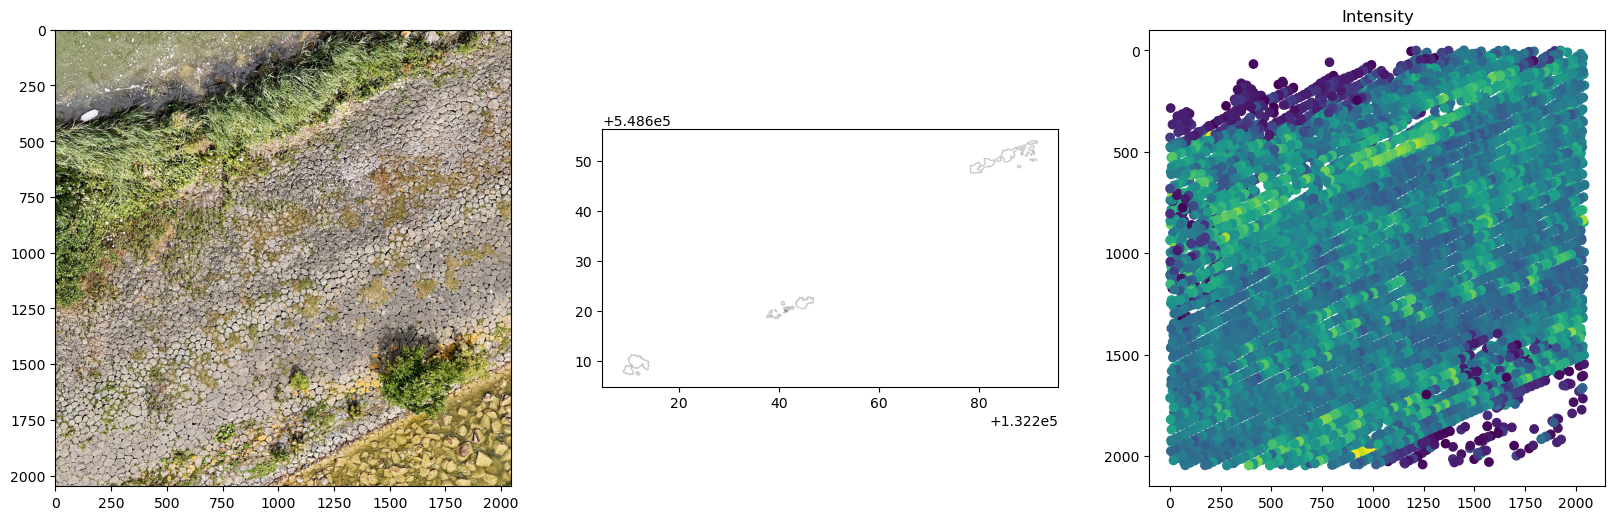

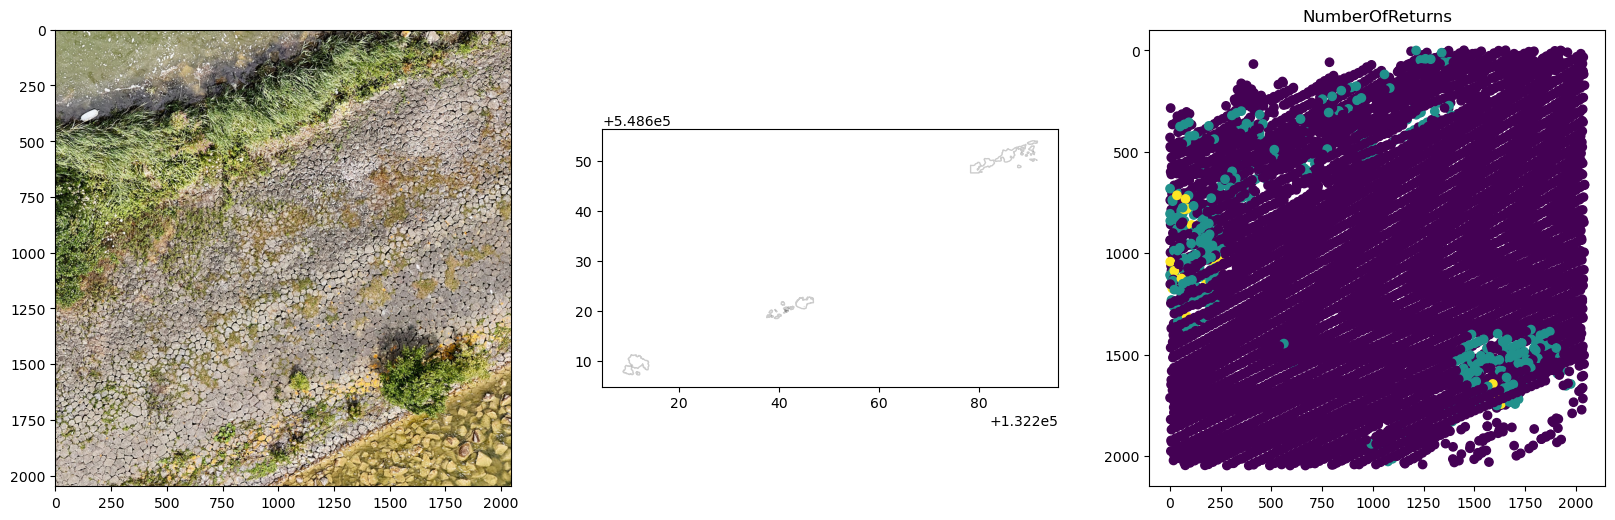

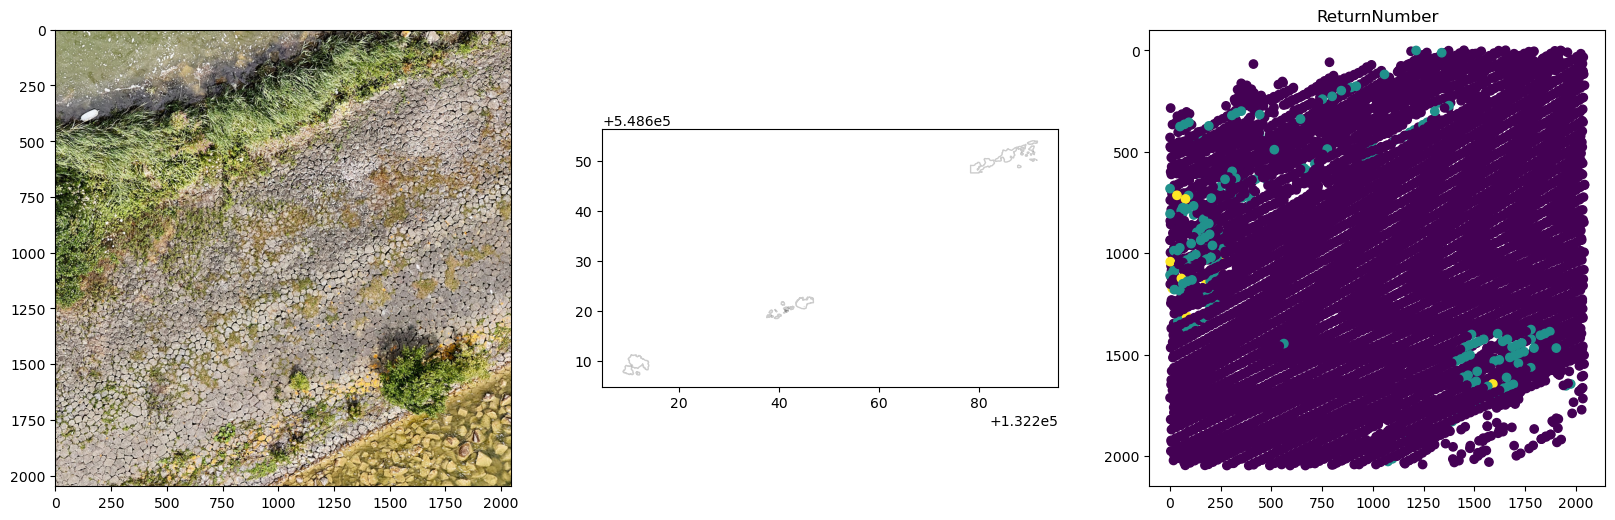

In [158]:
# Function to assign color based on category
def assign_color(category):
    return {"grass": "green", "road": "grey", "bush": "purple", "stone": "brown"}.get(
        category, "black"
    )  # default color if no match


# Adding a new column for color
group["color"] = group["category"].apply(assign_color)
group

for filter_column in ["Intensity", "NumberOfReturns", "ReturnNumber"]:

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(imgRGB)
    group.plot(
        ax=ax[1], edgecolor=group["color"], facecolor="white", alpha=0.2, zorder=0
    )
    # gdf_tags_tile[gdf_tags_tile['category']=="bush"].plot(ax=ax[1], color=gdf_tags_tile[gdf_tags_tile['category']=="bush"]['color'], alpha=1, zorder=1)
    lp1.plot(column=filter_column, ax=ax[2])  # , alpha=.8, cmap='Greys')
    gdf_selected_las_data.plot(column=filter_column, ax=ax[2])
    ax[2].set_ylim(ax[2].get_ylim()[::-1])
    ax[2].set_title(filter_column)

In [190]:
for filter_column in ["Intensity", "NumberOfReturns", "ReturnNumber"]:
    print(
        f"Selected {filter_column} mean: {gdf_selected_las_data[filter_column].mean()}"
    )
    print(f"{filter_column} mean: {lp1[filter_column].mean()}")

    # return number min max
    # number of return, mean + max

    print()

Selected Intensity mean: 2691.240174672489
Intensity mean: 2621.1197831087743

Selected NumberOfReturns mean: 1.3056768558951966
NumberOfReturns mean: 1.0806769635228393

Selected ReturnNumber mean: 1.1353711790393013
ReturnNumber mean: 1.0404206375287546



In [186]:
lp1["Intensity"].mean()

2621.1197831087743